# 머신러닝   
       
9주 1강: Linear Regression 실습2|

숭실대학교<br/>
AI융합학부<br/>
윤진혁<br/>

# 경사하강법 Remind
* 경사하강법(gradient descent): 경사를 하강하면서 수식을 최소화하는 매개변수의 값을 찾아내는 방법
* 점이 최솟값을 달성하는 방향으로 점점 내려갑니다
  * 몇 번 적용할 것인가? : 많이 실행할수록 최솟값에 가까워집니다. 다만 시간이 더 많이 걸립니다.
  * 한 번에 얼마나 많이 내려갈 것인가?: 한 번에 얼마나 많은 공간을 움직일지? 
  * 경사(gradient) : 경사하강법의 하이퍼 매개변수
* 경사하강법의 변형
  * Full Batch: 전체 데이터를 한번에
  * Mini-batch: 데이터를 조각족가내서 일부씩
  * Stochastic: 데이터를 셔플링해서 (혹은 확률적으로 샘플링해서) 하나씩!

In [4]:
class LinearRegressionGD(object): # 한 번에 되는 것으로 만들어 봅시다.
    def __init__(self, fit_intercept=True, copy_X=True,
                 eta0=0.001, epochs=1000, batch_size = 1, 
                 weight_decay=0.9, shuffle = True):
        self.fit_intercept = fit_intercept
        self.copy_X = copy_X
        self._eta0 = eta0
        self._epochs = epochs

        self._cost_history = []

        self._coef = None
        self._intercept = None
        self._new_X = None
        self._w_history = None
        self._weight_decay = weight_decay
        self._batch_size = batch_size
        self._is_SGD = shuffle

    def gradient(self, X, y, theta):
        return X.T.dot(self.hypothesis_function(X, theta)-y) / len(X)

    def fit(self, X, y):
        self._new_X = np.array(X)  # X 데이터 할당
        y = y.reshape(-1, 1)

        if self.fit_intercept:    # intercept 추가 여부
            # 1로만 구성된 상수항을 모든 데이터를 추가
            intercept_vector = np.ones([len(self._new_X), 1])
            self._new_X = np.concatenate(
                    (intercept_vector, self._new_X), axis=1)

        theta_init = np.random.normal(0, 1, self._new_X.shape[1])         
        # weight값 초기화
        self._w_history = [theta_init]
        self._cost_history = [self.cost(
                        self.hypothesis_function(self._new_X, theta_init), y)]

        theta = theta_init

        for epoch in range(self._epochs): # 지정된 epoch의 값만큼 학습 실행
            X_copy = np.copy(self._new_X)

            if self._is_SGD:   # stochastic 적용 여부
                np.random.shuffle(X_copy)

            batch = len(X_copy) // self._batch_size 
            # batch 사이즈를 기준으로 전체데이터를 나눔

            for batch_count  in range(batch):
                X_batch = np.copy(   # BATCH 사이즈를 기준으로 데이터를 slice
                            X_copy[batch_count * self._batch_size : (batch_count+1) & self._batch_size])

                gradient = self.gradient(X_batch  , y, theta).flatten()
                theta = theta - self._eta0 * gradient

            if epoch % 100 == 0:
                self._w_history.append(theta)
                cost = self.cost(
                    self.hypothesis_function(self._new_X, theta), y)
                self._cost_history.append(cost)
            self._eta0 = self._eta0 * self._weight_decay

        if self.fit_intercept:
            self._intercept = theta[0]
            self._coef = theta[1:]
        else:
            self._coef = theta
    def cost(self, h, y):
        return 1/(2*len(y)) * np.sum((h-y).flatten() ** 2)

    def hypothesis_function(self, X, theta):
        return X.dot(theta).reshape(-1, 1) # 선형회귀니까요.

    def gradient(self, X, y, theta):
        return X.T.dot(self.hypothesis_function(X, theta)-y) / len(X)

    def fit(self, X, y):
        self._new_X = np.array(X)
        y = y.reshape(-1, 1)

        if self.fit_intercept:
            intercept_vector = np.ones([len(self._new_X), 1])
            self._new_X = np.concatenate(
                    (intercept_vector, self._new_X), axis=1)

        theta_init = np.random.normal(0, 1, self._new_X.shape[1])
        self._w_history = [theta_init]
        self._cost_history = [self.cost(
                        self.hypothesis_function(self._new_X, theta_init), y)]

        theta = theta_init

        for epoch in range(self._epochs):
            gradient = self.gradient(self._new_X, y, theta).flatten()
            theta = theta - self._eta0 * gradient

            if epoch % 100 == 0: # epoch 100마다 cost function 기록
                self._w_history.append(theta)
                cost = self.cost(
                    self.hypothesis_function(self._new_X, theta), y)
                self._cost_history.append(cost)
            self._eta0 = self._eta0 * self._weight_decay 

        if self.fit_intercept:
            self._intercept = theta[0]
            self._coef = theta[1:]
        else:
            self._coef = theta

    def predict(self, X):
        test_X = np.array(X)

        if self.fit_intercept:
            intercept_vector = np.ones([len(test_X), 1])
            test_X = np.concatenate(
                    (intercept_vector, test_X), axis=1)

            weights = np.concatenate(([self._intercept], self._coef), axis=0)
        else:
            weights = self._coef

        return test_X.dot(weights)

    @property
    def coef(self):
        return self._coef

    @property
    def intercept(self):
        return self._intercept

    @property
    def weights_history(self):
        return np.array(self._w_history)

    @property
    def cost_history(self):
        return self._cost_history

* Train file을 불러와서 fitting 해 봅시다 모두 10000 epoch씩 돌리기로. 

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("./W09/train.csv")

X = df["x"].values.reshape(-1,1)
y = df["y"].values

gd_lr = LinearRegressionGD(eta0=0.001, epochs=10000, batch_size=1, shuffle=False)
bgd_lr = LinearRegressionGD(eta0=0.001, epochs=10000, batch_size=len(X), shuffle=False)
sgd_lr = LinearRegressionGD(eta0=0.001, epochs=10000, batch_size=1, shuffle=True)
msgd_lr = LinearRegressionGD(eta0=0.001, epochs=10000, batch_size=100, shuffle=True)

In [5]:
gd_lr.fit(X, y)
bgd_lr.fit(X, y)
sgd_lr.fit(X,y)
msgd_lr.fit(X,y)

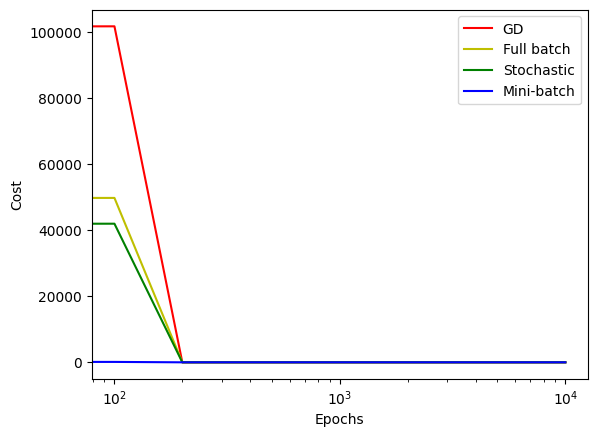

In [6]:
import matplotlib.pyplot as plt

res = 100 # 100 epoch마다 기록했으므로.

plt.plot(np.arange(len(gd_lr.cost_history))*res, gd_lr.cost_history, c="r", label="GD")
plt.plot(np.arange(len(bgd_lr.cost_history))*res, bgd_lr.cost_history, c="y", label="Full batch")
plt.plot(np.arange(len(sgd_lr.cost_history))*res, sgd_lr.cost_history, c="g", label="Stochastic")
plt.plot(np.arange(len(msgd_lr.cost_history))*res, msgd_lr.cost_history, c="b", label="Mini-batch")

plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.legend()
#plt.yscale("log")
plt.xscale("log")

## Scikit-learn으로 선형회귀 구현하기
* 기본적으로 아래의 함수들이 있습니다
  * Linear Regression: Least-squared로 계산
  * Lasso: L1 loss 보정을 한 라쏘 알고리즘으로 계산 (Least Squared)
  * Ridge: L2 loss 보정을 한 리지 알고리즘으로 계산 (Least SquareD)
  * SDG Regressor: Stochastic GD를 사용한 회귀모형을 만듭니다
  
* 일단 다시 한 번 boston 집값 데이터셋을 읽어옵시다. 
  * 교과서는 load_boston 함수 쓰라고 했습니다만, 윤리적 문제로 이제 sklearn에서는 삭제가 되었습니다.
  * 저도 쓰고싶지 않은 데이터지만... 교과서에 충실하기 위해 일단 불러와 봅시다

In [7]:
import matplotlib.pyplot as plt
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [8]:
data # x 데이터입니다.

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [9]:
target = target.reshape(target.size, 1) # (506,) -> (506,1)로 shape 를 바꿔줍시다
target.shape

(506, 1)

In [10]:
data.shape # Feature는 13개가 있습니다

(506, 13)

In [11]:
from sklearn import preprocessing # minmax scaling을 해 줍시다. 

minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,5)).fit(data) # (1)
x_scaled_data = minmax_scale.transform(data) # (2)

x_scaled_data[:3] 

array([[0.00000000e+00, 9.00000000e-01, 3.39076246e-01, 0.00000000e+00,
        1.57407407e+00, 2.88752635e+00, 3.20803296e+00, 1.34601570e+00,
        0.00000000e+00, 1.04007634e+00, 1.43617021e+00, 5.00000000e+00,
        4.48399558e-01],
       [1.17961270e-03, 0.00000000e+00, 1.21151026e+00, 0.00000000e+00,
        8.64197531e-01, 2.73998850e+00, 3.91349125e+00, 1.74480990e+00,
        2.17391304e-01, 5.24809160e-01, 2.76595745e+00, 5.00000000e+00,
        1.02235099e+00],
       [1.17848872e-03, 0.00000000e+00, 1.21151026e+00, 0.00000000e+00,
        8.64197531e-01, 3.47192949e+00, 2.99691040e+00, 1.74480990e+00,
        2.17391304e-01, 5.24809160e-01, 2.76595745e+00, 4.94868627e+00,
        3.17328918e-01]])

In [12]:
from sklearn.model_selection import train_test_split # 학습데이터와 테스트 데이터를 나눠줍시다

X_train, X_test, y_train, y_test = train_test_split(x_scaled_data, target, test_size=0.33)
# X 데이터의 학습 데이터셋, X 데이터의 테스트 데이터셋
# Y 데이터의 학습 데이터셋, Y 데이터의 테스트 데이터셋

X_train.shape, X_test.shape, y_train.shape, y_test.shape
# ((339, 13), (167, 13), (339, 1), (167, 1))

((339, 13), (167, 13), (339, 1), (167, 1))

In [13]:
from sklearn import  linear_model

regr = linear_model.LinearRegression(fit_intercept=True, copy_X=True, n_jobs=8) 
lasso_regr = linear_model.Lasso(alpha=0.01, fit_intercept=True, copy_X=True)
ridge_regr = linear_model.Ridge(alpha=0.01, fit_intercept=True, copy_X=True)
SGD_regr = linear_model.SGDRegressor(penalty="l2", alpha=0.01, max_iter=1000, tol=0.001, eta0=0.01)

In [14]:
# 각 모델을 fitting 합시다
regr.fit(X_train, y_train) 
lasso_regr.fit(X_train, y_train)
ridge_regr.fit(X_train, y_train)
SGD_regr.fit(X_train, y_train.reshape(-1))

SGDRegressor(alpha=0.01)

In [15]:
print('Coefficients: ', regr.coef_)
print('intercept: ', regr.intercept_)

Coefficients:  [[-2.44066936  0.9191128   0.01348631  0.55869922 -1.94711622  3.46840047
   0.31566211 -3.40234373  1.48362234 -1.20987385 -1.74221719  0.59597005
  -4.30094756]]
intercept:  [28.8397321]


In [16]:
regr.predict(X_train[:5])

array([[ 7.65393323],
       [ 6.69570665],
       [25.08263549],
       [23.17625555],
       [30.56718568]])

In [17]:
X_train[:5].dot(regr.coef_.T) + regr.intercept_

array([[ 7.65393323],
       [ 6.69570665],
       [25.08263549],
       [23.17625555],
       [30.56718568]])

In [18]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

y_true = y_test.copy()
y_hat_regr = regr.predict(X_test)
y_hat_lasso = lasso_regr.predict(X_test)
y_hat_ridge = ridge_regr.predict(X_test)
y_hat_sgd = SGD_regr.predict(X_test)

print("linear regression:", r2_score(y_true, y_hat_regr), mean_absolute_error(y_true, y_hat_regr), mean_squared_error(y_true, y_hat_regr), "\n", 
      "lasso regression:", r2_score(y_true, y_hat_lasso), mean_absolute_error(y_true, y_hat_lasso), mean_squared_error(y_true, y_hat_lasso), "\n",
      "ridge regression:", r2_score(y_true, y_hat_ridge), mean_absolute_error(y_true, y_hat_ridge), mean_squared_error(y_true, y_hat_ridge), "\n",
      "sgd regression:", r2_score(y_true, y_hat_sgd), mean_absolute_error(y_true, y_hat_sgd), mean_squared_error(y_true, y_hat_sgd), )

linear regression: 0.7619012361966464 3.378330736850305 20.141109351223747 
 lasso regression: 0.7624300047559475 3.371288631417815 20.096380075001345 
 ridge regression: 0.7619055563609962 3.378282240145615 20.140743902444445 
 sgd regression: 0.7230834630933427 3.570733110620989 23.42475938096665


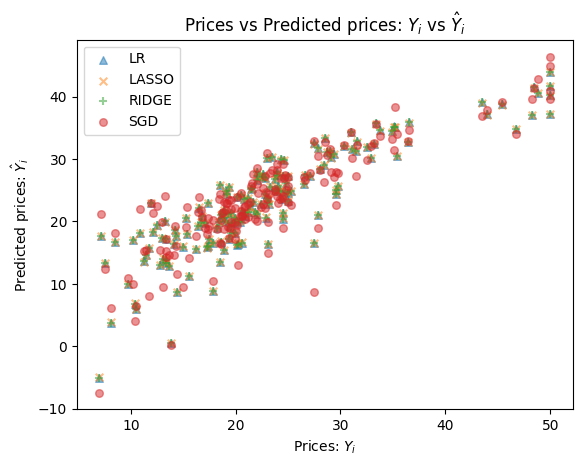

In [19]:
# 그림을 그려봅시다
ps = 30
alp = 0.5
plt.scatter(y_true, y_hat_regr, s=ps, alpha=alp, marker='^', label="LR")
plt.scatter(y_true, y_hat_lasso, s=ps, alpha=alp, marker="x", label="LASSO")
plt.scatter(y_true, y_hat_ridge, s=ps, alpha=alp, marker="+", label="RIDGE")
plt.scatter(y_true, y_hat_sgd, s=ps, alpha=alp, label="SGD")
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\\hat{Y}_i$")
plt.legend()
# SGD를 제외하고 거의 비슷한 결과임을 알 수 있습니다
# SGD는 파라미터를 바꾸고 학습을 더 하면 더 정확해질 수 있습니다.

## minmax scaling?

In [20]:
from sklearn.model_selection import train_test_split # 학습데이터와 테스트 데이터를 나눠줍시다

X_train2, X_test2, y_train2, y_test2 = train_test_split(data, target, test_size=0.33)
# X 데이터의 학습 데이터셋, X 데이터의 테스트 데이터셋
# Y 데이터의 학습 데이터셋, Y 데이터의 테스트 데이터셋

X_train.shape, X_test.shape, y_train.shape, y_test.shape
# ((339, 13), (167, 13), (339, 1), (167, 1))

((339, 13), (167, 13), (339, 1), (167, 1))

In [21]:
regr2 = linear_model.LinearRegression(fit_intercept=True, copy_X=True, n_jobs=8) 
lasso_regr2 = linear_model.Lasso(alpha=0.01, fit_intercept=True, copy_X=True)
ridge_regr2 = linear_model.Ridge(alpha=0.01, fit_intercept=True, copy_X=True)
SGD_regr2 = linear_model.SGDRegressor(penalty="l2", alpha=0.01, max_iter=100000000000, tol=0.001, eta0=0.01)

In [22]:
regr.fit(X_train2, y_train2) 
lasso_regr.fit(X_train2, y_train2)
ridge_regr.fit(X_train2, y_train2)
SGD_regr.fit(X_train2, y_train2.reshape(-1))

SGDRegressor(alpha=0.01)

In [23]:
y_true2 = y_test2.copy()
y_hat_regr2 = regr.predict(X_test2)
y_hat_lasso2 = lasso_regr.predict(X_test2)
y_hat_ridge2 = ridge_regr.predict(X_test2)
y_hat_sgd2 = SGD_regr.predict(X_test2)

print("linear regression:", r2_score(y_true2, y_hat_regr2), mean_absolute_error(y_true2, y_hat_regr2), mean_squared_error(y_true2, y_hat_regr2), "\n", 
      "lasso regression:", r2_score(y_true2, y_hat_lasso2), mean_absolute_error(y_true2, y_hat_lasso2), mean_squared_error(y_true2, y_hat_lasso2), "\n",
      "ridge regression:", r2_score(y_true2, y_hat_ridge2), mean_absolute_error(y_true2, y_hat_ridge2), mean_squared_error(y_true2, y_hat_ridge2), "\n",
      "sgd regression:", r2_score(y_true2, y_hat_sgd2), mean_absolute_error(y_true2, y_hat_sgd2), mean_squared_error(y_true2, y_hat_sgd2), )

linear regression: 0.7190734785369461 3.283986127153545 19.09219389769942 
 lasso regression: 0.7209526458439389 3.2642651713954924 18.964482827899115 
 ridge regression: 0.7192093919820637 3.2824280105546255 19.082957013143364 
 sgd regression: -1.6670122407680254e+25 24605099938909.406 1.1329268865334687e+27


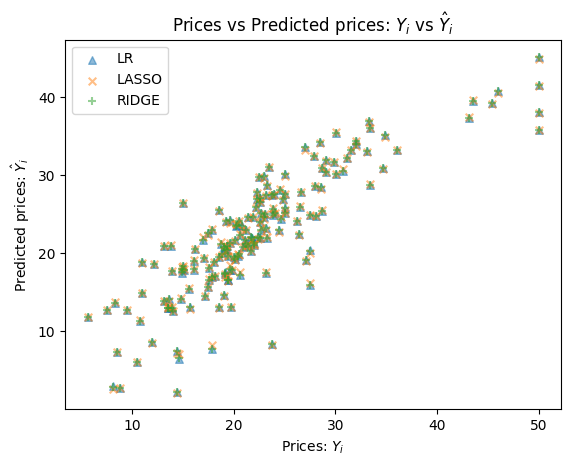

In [24]:
# 그림을 그려봅시다
ps = 30
alp = 0.5
plt.scatter(y_true2, y_hat_regr2, s=ps, alpha=alp, marker='^', label="LR")
plt.scatter(y_true2, y_hat_lasso2, s=ps, alpha=alp, marker="x", label="LASSO")
plt.scatter(y_true2, y_hat_ridge2, s=ps, alpha=alp, marker="+", label="RIDGE")
#plt.scatter(y_true2, y_hat_sgd2, s=ps, alpha=alp, label="SGD")
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\\hat{Y}_i$")
plt.legend()
# SGD를 제외하고 거의 비슷한 결과임을 알 수 있습니다
# SGD는 파라미터를 바꾸고 학습을 더 하면 더 정확해질 수 있습니다.